In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

sns.set(font_scale=1.4)

## In Class Assignment 1

1. Using the dataset of taxi cab rides, lets see how much progress we can make reverse-engineering the pricing structure into the form:

`total` = a_0 + a_1 * `distance` + a_2 * `tolls` + a_3 * `tip` + a_4 * `fare` + a_5 * `passengers`

so that one can predict the cost of future rides.

2. Are you sure that this formula is the same that the taxi uses?  Explain why or why not
    - synthesize your real world knowledge of cab rides with the results

3. (++) We expect `tip` and `tolls` to be passed directly onto customer (forcing their `a_i` coefficient to be exactly one above).  How can we build a model which accomplishes this while still optimizing the other coefficients?

In [2]:
df_taxi = sns.load_dataset('taxis')
df_taxi.head()

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan


In [3]:
def disp_regress(df, x_feat_list, y_feat, verbose=True):
    """ linear regression, displays model w/ coef
    
    Args:
        df (pd.DataFrame): dataframe
        x_feat_list (list): list of all features in model
        y_feat (list): target feature
        verbose (bool): toggles command line output
        
    Returns:
        reg (LinearRegression): model fit to data
    """
    # initialize regression object
    reg = LinearRegression()

    # get target variable
    # (note: since we index with list -> garauanteed 2d x array, no reshape needed)
    x = df.loc[:, x_feat_list].values
    y = df.loc[:, y_feat].values

    # fit regression
    reg.fit(x, y)

    # compute / store r2
    y_pred = reg.predict(x)
    
    if verbose:
        # print model   
        model_str = y_feat + f' = {reg.intercept_:.2f}'
        for feat, coef in zip(x_feat_list, reg.coef_):
            s_sign = ' - ' if coef < 0 else ' + '
            model_str += s_sign + f'{np.abs(coef):.2f} {feat}'
        print(model_str)

        # compute / print r2
        r2 = r2_score(y_true=y, y_pred=y_pred)
        print(f'r2 = {r2:.5} (not cross validated)')
    
    return reg

In [4]:
#predicting the cost of rides
disp_regress(df=df_taxi, y_feat='total', x_feat_list = ['distance', 'tolls', 'tip', 'fare', 'passengers']
);

total = 3.10 - 0.01 distance + 1.02 tolls + 1.17 tip + 0.97 fare + 0.06 passengers
r2 = 0.99402 (not cross validated)


### Response:
Although this formula has a r^2 of 99.4%, it is not the ones that the taxi use. Taxis do not consider the number of passengers into the total cost nor give discounts for longer distances. In additional, there is no constant multiplier for tips. Passengers will give tips according to their own opinions.

# In Class Assignment 2

For the `first_month_covid_us.csv` dataset
1. scatter `day` & `total_cases`
    - between February 22 and March 22, 2020 (whole csv)
1. fit an exponential model to the data
1. compute / print a (not cross validated) r2 value of the exponential model
1. (extra) print a string which shows the model itself


$$ \hat{y} = \alpha_0 e^{a_1 x} $$

In [5]:
df_covid = pd.read_csv('first_month_covid_us.csv', index_col='date')

df_covid.head()

,day,total_cases
date,,
2020-02-22,0,7.0
2020-02-23,1,8.0
2020-02-24,2,9.0
2020-02-25,3,10.0
2020-02-26,4,12.0


In [6]:
x_feat = 'day'
y_feat = 'total_cases'

x = df_covid.loc[:, x_feat].values
y = df_covid.loc[:, y_feat].values

# reshape
x = x.reshape(-1,1)

# initialize linear regression
reg = LinearRegression()

# fit & predict
reg.fit(x, np.log(y))
y_hat = np.exp(reg.predict(x))

# compute r2
r2 = r2_score(y_true = y, y_pred = y_hat)

# extract coefficient
a_0 = reg.intercept_
a_1 = reg.coef_[0]
alpha0 = np.exp(a_0)

print('r2 =', r2)

r2 = 0.9053514782592941


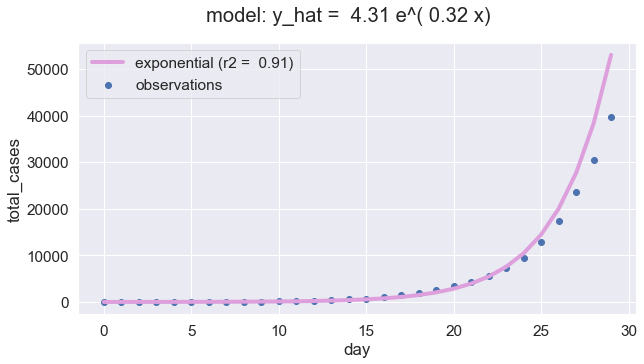

In [7]:
# plot
title = f'model: y_hat = {alpha0: .2f} e^({a_1: .2f} x)'
plt.scatter(x, y, label='observations')
plt.plot(x, y_hat, linewidth=4, color='plum', label = f'exponential (r2 = {r2: .2f})')
plt.xlabel(x_feat)
plt.ylabel(y_feat)
plt.legend()
plt.suptitle(title)
plt.gcf().set_size_inches(10,5)
            

# ICA 3
Using the x and y data generated below:

1. Write a function `fit_plot_poly(x, y, degree)`:
    - projects raw x in to polynomial features of some `degree`
    - fits a polynomial regression model
    - plots the result
        - add degree of model in title
        
1. Loop over your `fit_plot_poly()` function to fit polynomials of degree 0, 1, 2, 3, ... 10 and respond to the questions below:
    - what do you notice about r^2 as the degree of the polynomial increases
    - is the polynomial with the lowest r^2 the best model (hint: no).  Why not?
        - (++) for a more compelling example, try reducing the number of observations to 11 ...
            - its tough to see the behavior of the polynomial between the 11 observatoins (should look piecewise linear).  try making and predicting a finer grained x in your `fit_plot_poly()` which allows you to observe the polynomial's behavior
   

In [8]:
def get_poly_data(coef, x, std_dev=20):
    """ computes noisy data from a polynomial
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
        noise (float): std deviation of noise
        
    Returns:
        x (np.array): input values (gauranteed 2d array)
        y (np.array): noisy poly data
    """
    np.random.seed(0)
    y = poly(x, coef) 
    
    # add some noise
    y = y + np.random.standard_normal(x.size) * std_dev
    
    # reshape into sklearn standard (n_samples, n_features)
    x = x.reshape(-1, 1)
    return x, y

In [9]:
def poly(x, coef):
    """ computes polynomials in x
    
    to represent the polynomial:
    
    a_0 x^0 + a_1 x^1 + a_2 x^2 + a_3 x^3 + ...
    
    coef = [a_0, a_1, a_2, a_3, ...]
    
    Args:
        x (np.array): input values
        coef (np.array): coefficients of polynomial
        
    Returns:
        y (np.array): polynomial evaluated at every x
    """
    # initialize y as array of zeros
    y = np.zeros_like(x)
    
    # adds each monomial one at a time
    for deg, a in enumerate(coef):
        y += a * x ** deg
        
    return y 

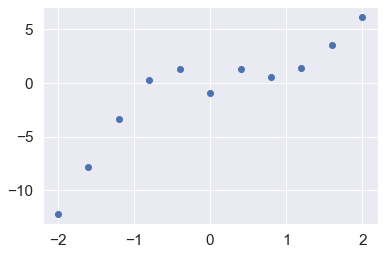

In [10]:
# initialize a polynomial and its domain
coef = np.array([0, 1, -1, 1])
x = np.linspace(-2, 2, 11)
x, y = get_poly_data(coef=coef, x=x, std_dev=1)
plt.scatter(x, y)

In [11]:
def fit_plot_poly(x, y, degree):
    """ dits and plots a polynomial of given degree
    
    Args:
        x (np.array): (n_samples, 1) array of x inputs
        y (np.array): (n_sample, 1) array of target values
        degree (int): max degree of polynomial
    """
    
    # project x
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(x)
    
    # fit via linear regression
    reg = LinearRegression(fit_intercept=False)
    reg.fit(x_poly, y)
    
    # predict y
    x_fine = np.linspace(x.min(), x.max(), 101).reshape(-1,1)
    x_fine_poly = poly.fit_transform(x_fine)
    y_pred_fine = reg.predict(x_fine_poly)
    
    
    # compute r2
    y_pred = reg.predict(x_poly)
    r2 = r2_score(y_true = y, y_pred = y_pred)
    
    # plot
    plt.plot(x_fine, y_pred_fine, label=f'no scross val r2={r2: .3f}', 
             color='r', linewidth=3)
    plt.scatter(x, y, label=f'observed', color='k')
    plt.legend()

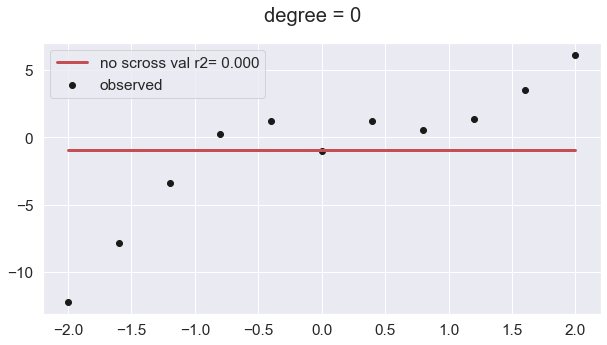

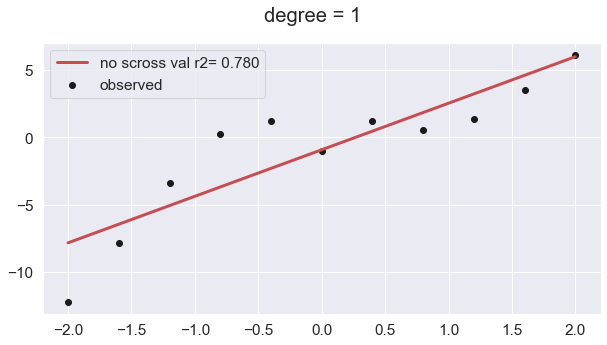

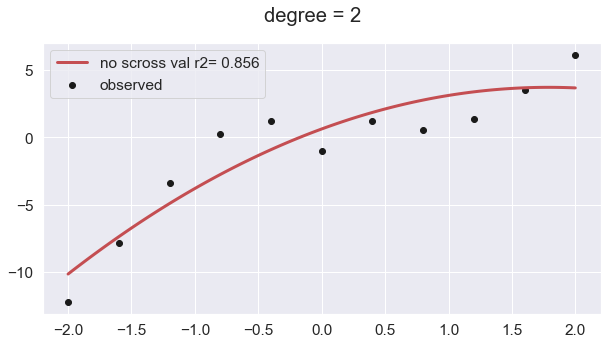

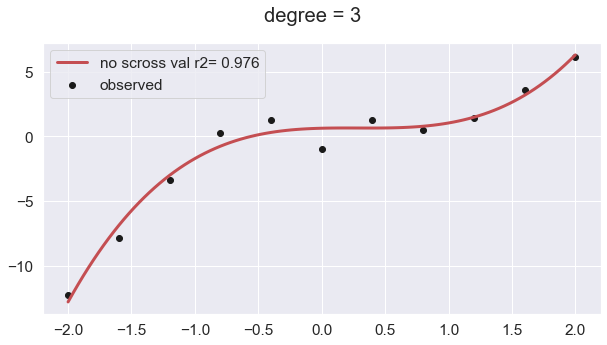

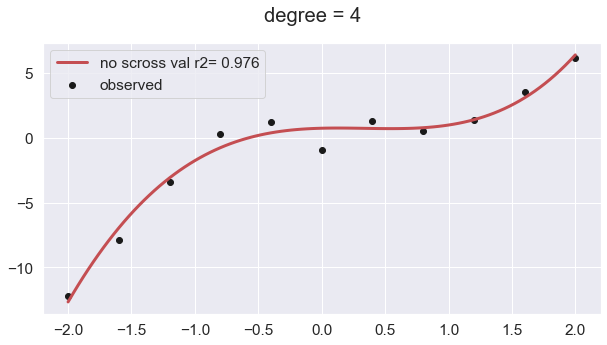

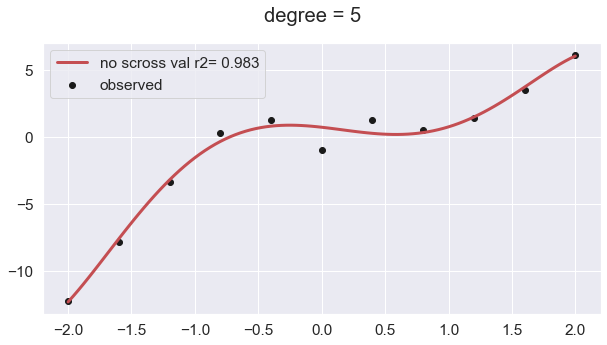

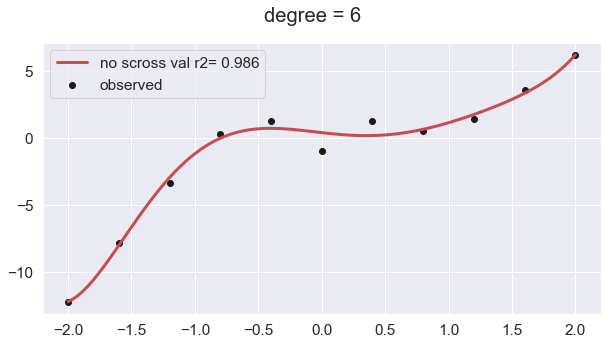

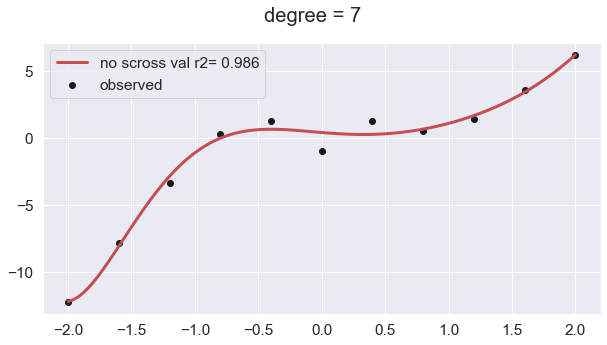

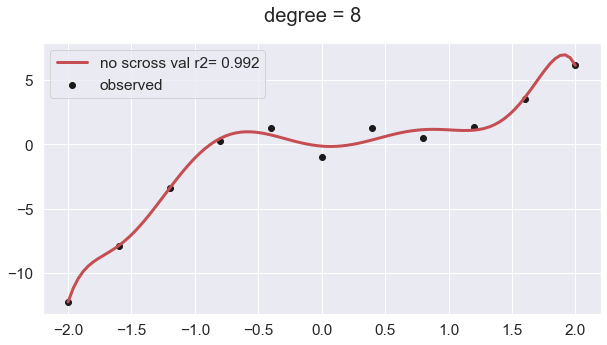

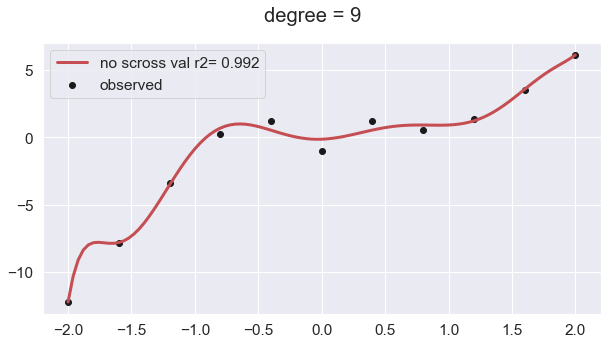

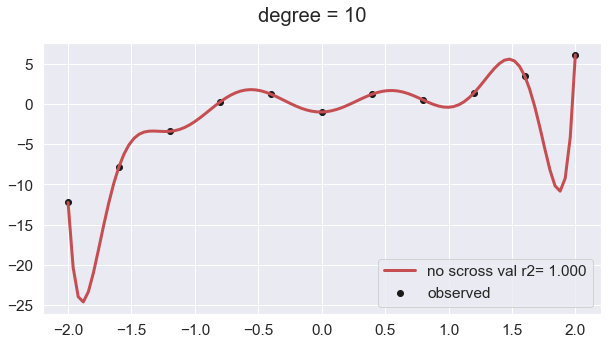

In [12]:
for degree in range(11):
    # figure for every degree
    plt.figure()
    
    fit_plot_poly(x, y, degree)
    plt.suptitle(f'degree = {degree}')
    plt.gcf().set_size_inches(10,5)

### Response
As the degree increases, the model becomes more flexible. The polynomial with the lowest r^2 is not the best model because r^2 is 0 and the model (line) does not fit good with the data as shown in degree 0 graph.